In [ ]:
cd "set to where your repo is"

/Users/yuyaogawa/Working/mg


In [2]:
import gc
gc.collect()

0

In [3]:
import polars as pl
import xgboost as xgb
import pandas as pd
import numpy as np
import duckdb
import os
from functions.loan_xgb import train_bootstrap, process_chunk
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
# Set the parameters here

# -------------------------
# 1. Scan Parquet lazily
# -------------------------
basepath = "Set to where you stored your data"
loan_df = pl.scan_parquet(f"{basepath}/loan_data.parquet")
loan_df_train = loan_df.filter(pl.col("MONTHLY_REPORTING_PERIOD").str.slice(0,4).cast(pl.Int64) <= 2021)
val_df = loan_df.filter(pl.col("MONTHLY_REPORTING_PERIOD").str.slice(0,4).cast(pl.Int64) > 2021)
# -------------------------
# 2. Select features and target
# -------------------------
features = [
    "ORIGINAL_LOAN_TERM",
    "LOAN_AGE",
    "ORIGINAL_LOAN_TO_VALUE",
    "ORIGINAL_DEBT_TO_INCOME",
    "CREDIT_SCORE",
    "INTEREST_RATE_DIFF",
    "UNEMPLOYMENT"
]
target = "DELINQUENT"
# -------------------------
# 3. Bootstrapped sampling by unique loans
# -------------------------
n_bootstrap = 100
sub_sample_size = 0.01
n_workers = 8 # parallel processing


n_trees = 100
learning_rate = 0.05
var_choice = 0.6
n_treesplit = 10

run = 3

# number of total bootstrapping is 100*5

# -------------------------
# 4. Export the prediction
# -------------------------
chunk_size = 100_000


In [5]:
# Collect unique loans once
unique_loans = loan_df.select("LOAN_SEQUENCE_NUMBER").unique().collect()
unique_loans_list = unique_loans["LOAN_SEQUENCE_NUMBER"].to_list()

xgb_models = []

with ThreadPoolExecutor(max_workers=n_workers) as executor:
    futures = [executor
               .submit(train_bootstrap, 
                       loan_df=loan_df_train, 
                       unique_loans = unique_loans_list, 
                       features = features, 
                       target =target,
                       sample_frac=sub_sample_size,
                       n_estimators=n_trees) for _ in range(n_bootstrap)]
    
    for future in tqdm(as_completed(futures), total=n_bootstrap, desc="Bootstrapped Models"):
        xgb_models.append(future.result())

Bootstrapped Models: 100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


In [6]:
# -------------------------
# 4. Aggregate predictions on a small sample
# -------------------------
duckdb_file = os.path.join(basepath, f"prediction{run}.duckdb")
table_name = "prediction"
chunk_size = 100_000

# Ensure DuckDB table exists
conn = duckdb.connect(duckdb_file)
conn.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        LOAN_SEQUENCE_NUMBER STRING,
        MONTHLY_REPORTING_PERIOD STRING,
        DELINQUENT INT,
        DELINQ_PROB DOUBLE
    )
""")
conn.close()  # Each thread can connect independently

# Total rows and offsets
num_rows = val_df.collect().height
offsets = [(i, min(chunk_size, num_rows - i)) for i in range(0, num_rows, chunk_size)]

# Thread-based parallel processing
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(process_chunk, off, length, val_df, xgb_models, features, duckdb_file, table_name)
               for off, length in offsets]

    for f in tqdm(as_completed(futures), total=len(futures), desc="Scoring chunks (threads)"):
        rows_processed = f.result()

Scoring chunks (threads): 100%|██████████| 67/67 [06:19<00:00,  5.66s/it]


In [7]:
# -------------------------
# Compute Log Loss and Brier Score
# -------------------------
eps = 1e-15

# Connect to DuckDB
conn = duckdb.connect(duckdb_file)

# Load lazily via Arrow
df = pl.from_arrow(
    conn.execute("SELECT MONTHLY_REPORTING_PERIOD, DELINQUENT, DELINQ_PROB FROM prediction").arrow()
).lazy()

df_loss = (
    df.with_columns([
        # Clip probabilities to [eps, 1-eps]
        pl.col("DELINQ_PROB").alias("p_clip"),
    ])
    .with_columns([
        # Log loss per row
        -(pl.col("DELINQUENT") * pl.col("p_clip").log() + 
          (1 - pl.col("DELINQUENT")) * (1 - pl.col("p_clip")).log()).alias("log_loss_row"),
        # Brier score per row
        ((pl.col("DELINQ_PROB") - pl.col("DELINQUENT"))**2).alias("brier_row")
    ])
    .select([
        pl.mean("log_loss_row").alias("log_loss"),
        pl.mean("brier_row").alias("brier_score")
    ])
)

result = df_loss.collect()
print(result)


shape: (1, 2)
┌──────────┬─────────────┐
│ log_loss ┆ brier_score │
│ ---      ┆ ---         │
│ f64      ┆ f64         │
╞══════════╪═════════════╡
│ 0.082091 ┆ 0.017207    │
└──────────┴─────────────┘


In [8]:
monthly = df.group_by('MONTHLY_REPORTING_PERIOD').agg(
    pl.col("DELINQUENT").sum().alias('Total Delinquent'),
    pl.col("DELINQ_PROB").sum().alias('Predicted Delinquent'),
    (pl.col("DELINQ_PROB").sum() - pl.col("DELINQUENT").sum()).alias('Difference'),
    (pl.col("DELINQUENT").sum() / pl.len()).alias("Delinquent pct"),
    (pl.col("DELINQ_PROB").sum() / pl.len()).alias("Predicted delinquent pct")
).sort('MONTHLY_REPORTING_PERIOD').collect()

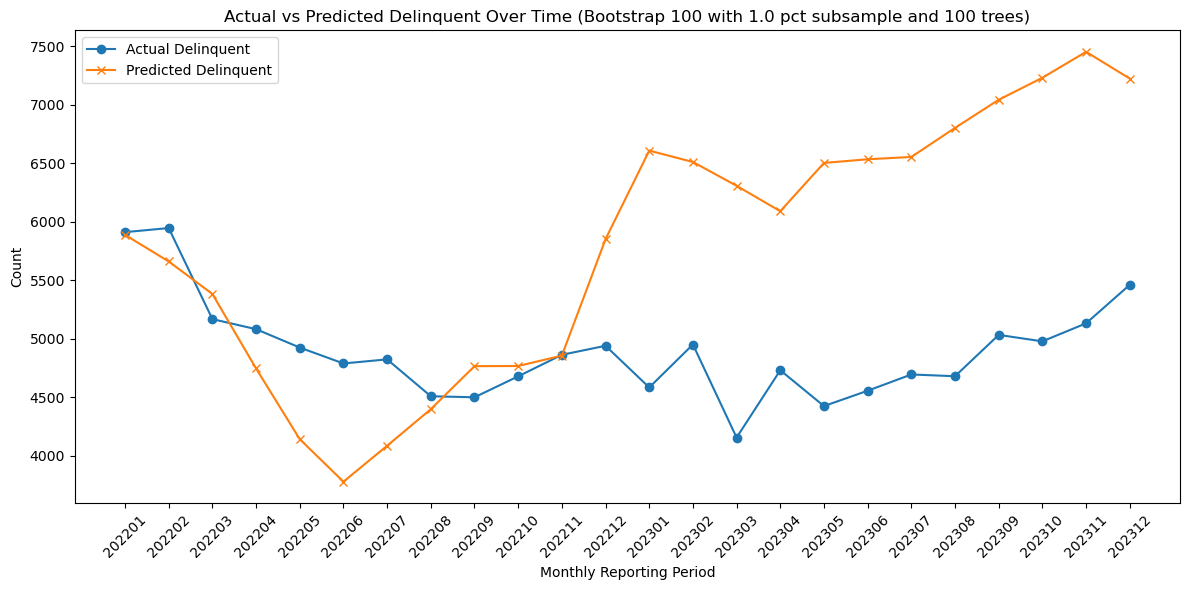

In [9]:
import matplotlib.pyplot as plt

# Convert to pandas
monthly_pd = monthly.to_pandas()

plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.plot(monthly_pd["MONTHLY_REPORTING_PERIOD"], monthly_pd["Total Delinquent"], label="Actual Delinquent", marker="o")
plt.plot(monthly_pd["MONTHLY_REPORTING_PERIOD"], monthly_pd["Predicted Delinquent"], label="Predicted Delinquent", marker="x")

plt.title(f"Actual vs Predicted Delinquent Over Time (Bootstrap {n_bootstrap} with {sub_sample_size*100} pct subsample and {n_trees} trees)")
plt.xlabel("Monthly Reporting Period")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"/Users/yuyaogawa/Documents/Home Work/portfolio/loan_forecast/Run{run}.png", dpi=300)
plt.show()